In [1]:
testing_loss = []

In [2]:
import os
import torch
import pickle

from MeLU import MeLU
from options import config
from model_training import training
from data_generation import generate
from evidence_candidate import selection
from tqdm import tqdm


if __name__ == "__main__":
    master_path= "./ml"
    if not os.path.exists("{}/".format(master_path)):
        os.mkdir("{}/".format(master_path))
        # preparing dataset. It needs about 22GB of your hard disk space.
        generate(master_path)

    # training model.
    melu = MeLU(config)
    state = "user_and_item_cold_state"
    model_filename = "{}/models_{}.pkl".format(master_path,state)
    if not os.path.exists(model_filename):
        # Load training dataset.
        training_set_size = int(len(os.listdir("{}/{}".format(master_path,state))) / 4)
        supp_xs_s = []
        supp_ys_s = []
        query_xs_s = []
        query_ys_s = []
        for idx in tqdm(range(training_set_size)):
            supp_xs_s.append(pickle.load(open("{}/{}/supp_x_{}.pkl".format(master_path,state, idx), "rb")))
            supp_ys_s.append(pickle.load(open("{}/{}/supp_y_{}.pkl".format(master_path, state, idx), "rb")))
            query_xs_s.append(pickle.load(open("{}/{}/query_x_{}.pkl".format(master_path, state, idx), "rb")))
            query_ys_s.append(pickle.load(open("{}/{}/query_y_{}.pkl".format(master_path, state, idx), "rb")))
        total_dataset = list(zip(supp_xs_s, supp_ys_s, query_xs_s, query_ys_s))
        del(supp_xs_s, supp_ys_s, query_xs_s, query_ys_s)
        history = training(melu, total_dataset, batch_size=config['batch_size'], num_epoch=config['num_epoch'], model_save=True, model_filename=model_filename)
    else:
        trained_state_dict = torch.load(model_filename)
        melu.load_state_dict(trained_state_dict)



C:\Users\rnautiyal2\Anaconda3\envs\charanfyp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 40/40 [11:49<00:00, 17.75s/it]


[13.287520170211792, 12.885660243034362, 12.422763681411743, 11.763086652755737, 10.657108640670776, 8.967741584777832, 6.559485590457916, 3.9560410618782043, 2.1706803500652314, 1.544286921620369, 1.425722736120224, 1.3627909108996392, 1.3221611946821212, 1.2847664281725883, 1.2582550063729285, 1.2361204281449318, 1.212939488887787, 1.1950696483254433, 1.1764476224780083, 1.1702468663454055, 1.1582102999091148, 1.1460864871740342, 1.1357889890670776, 1.1277162864804269, 1.1217650145292282, 1.1104034513235093, 1.1034826934337616, 1.0920632734894753, 1.0864311262965203, 1.0797490641474723, 1.0776500925421715, 1.070917969942093, 1.0649293512105942, 1.062210713326931, 1.056571763753891, 1.0540801838040352, 1.0515502959489822, 1.0483158126473426, 1.0439108610153198, 1.0397529557347298]


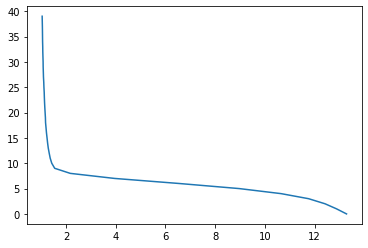

In [5]:
import matplotlib.pyplot as plt
y = list(range(len(history)))
print(history)
plt.plot(history,y)

In [6]:
# model_filename = "{}/models_{}.pkl".format(master_path,state)
# if not os.path.exists(model_filename):
# Load training dataset.
testing_set_size = int(len(os.listdir("{}/{}".format('testing',state))) / 4)
supp_xs_s = []
supp_ys_s = []
query_xs_s = []
query_ys_s = []
for idx in tqdm(range(testing_set_size)):
    supp_xs_s.append(pickle.load(open("{}/{}/supp_x_{}.pkl".format('testing',state, idx), "rb")))
    supp_ys_s.append(pickle.load(open("{}/{}/supp_y_{}.pkl".format('testing', state, idx), "rb")))
    query_xs_s.append(pickle.load(open("{}/{}/query_x_{}.pkl".format('testing', state, idx), "rb")))
    query_ys_s.append(pickle.load(open("{}/{}/query_y_{}.pkl".format('testing', state, idx), "rb")))

100%|██████████| 79/79 [00:00<00:00, 312.25it/s]


In [7]:
from torch.nn import functional as F
trained_state_dict = torch.load(model_filename)
melu.load_state_dict(trained_state_dict)

final_loss = []
for i in range(len(supp_xs_s)):
    prediction = melu.model(supp_xs_s[i].cuda())
    temp_loss = F.mse_loss(prediction, supp_ys_s[i].cuda().view(-1, 1))
    final_loss.append(temp_loss.item())

for j in range(len(query_xs_s)):
    prediction = melu.model(query_xs_s[j].cuda())
    temp_loss = F.mse_loss(prediction, query_ys_s[j].cuda().view(-1, 1))
    final_loss.append(temp_loss.item())

[1.066998288224015]


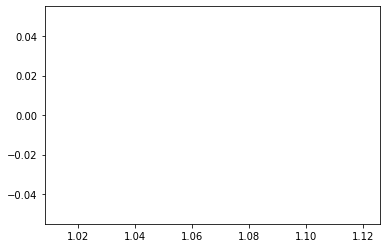

In [8]:
import numpy as np
testing_loss.append(np.mean(final_loss))
y = list(range(len(testing_loss)))
print(testing_loss)
plt.plot(testing_loss,y)